<a href="https://colab.research.google.com/github/LuSant22/Image-Preprocessing/blob/master/Tumor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Segmentation and Identification of MRI images using PCA


### Author: Luis Santana
### Universidad Autonoma de Guadalajara
### Image processing 
### Professor: Phd Ulises Moya


This project is based in the following scientific article:

- Development of Automated Brain Tumor Identification Using MRI Images 
- Authors: T. M. Shahriar Sazzad, K. M. Tanzibul Ahmmed, Misbah Ul Hoque, Mahmuda Rahman

Link: https://ieeexplore.ieee.org/document/8679240

# Introduction
In the following project it is implemented with the same methodology of the paper above, some image processing techniques were used to perform an efficient tumor segmentation from the MRI images in JPG format. Although for an effective identification and evaluation utilizing the PCA algotithm it is used a Validation dataset to verify the accuracy.


<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQXPqG0AI5O2LysWW2axtXsq9agSoDJpIqslDtl5pwvyaSexhun" width="300" align="center">

## Part I: Importing Libraries

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib


import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from random import randint
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix



%matplotlib inline

# Part II Pre-processing 

### Pre-processing steps


<img src="https://www.dropbox.com/s/uw38czfktpq5efr/Captura1.JPG?dl=1" width="300" align="center">

### A) Resize and label Images

- Here I extract all images and then I classiffy them with a label ("Yes" or "No").
- Then each image is read as Gray Scale
- Also it is performed a resize to 200 x 200

In [0]:
from sklearn.utils import shuffle
def get_images(directory):
    Images = []
    Labels = []  # 0 for No 1 for Yes
    label = 0
    
    for labels in os.listdir(directory): #Main Directory 
        if labels == 'no': #Folder that contains Yes and No Images
            label = 0
        elif labels =='yes':
            label = 1
    
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file, cv2.IMREAD_GRAYSCALE) #Reading the image (OpenCV) in Gray Scale
            image = cv2.resize(image,(200,200)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=80) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {0:'NO', 1:'YES'}
    
    return labels[class_code]

### Please change your directory according to your google drive dataset path, it is in the following link:  https://drive.google.com/open?id=1kbbmTdvGwxQcyD7udP2FSnckc_w_E3rf

In [151]:

from google.colab import drive

drive.mount('/content/gdrive/')
Dataset = os.path.join("/content/gdrive/My Drive/data/brain_tumor_dataset/")


Images, Labels = get_images(Dataset) 

BrainT_Images = np.array(Images) #converting the list of images to numpy array.
BrainT_Labels = np.array(Labels)



Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [152]:
print("Shape of Images:",BrainT_Images.shape)
print("Shape of Labels:",BrainT_Labels.shape)


Shape of Images: (244, 200, 200)
Shape of Labels: (244,)


In [153]:
BrainT_Labels

array([1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0])

## B) Cropping Images

Due to each image has a large black background, it is necessary to crop the Image.
This task is possible by first obtaining the tresholds and then finding contours for cropping in the extreme values.


In [0]:
import imutils
import cv2
 
def crop_img (Image_2Crop, pre_Img):

    thresh = cv2.erode(Image_2Crop, None, iterations=2)
    thresh = cv2.dilate(Image_2Crop, None, iterations=2)

    # find contours in thresholded image, then grab the largest one

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # determine the most extreme points along the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    
    y= extTop[1]
    x=extLeft[0]
    h=extBot[1]
    w=extRight[0]

    # Crop
    crop = pre_Img[y+10:h-10, x+10:w-10]
    
    return  crop



In [0]:
# Crop all images
crop_train =[]
ret2=[]
for i in range (len(BrainT_Images)):
    
    ret1,th1 = cv2.threshold(BrainT_Images[i],60,240,cv2.THRESH_BINARY)
    
    crop_train.append(th1)

In [0]:
for i in range(len(crop_train)):
    
    image = crop_img (crop_train[i],BrainT_Images[i])  
    
    crop_train[i] = cv2.resize(image,(200,200))
    

In [157]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.0, wspace=0.2)
fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                        subplot_kw={'xticks': [], 'yticks': []})

ax0.imshow(BrainT_Images[1],cmap='gray')
ax0.set_title('Original Img')
ax1.imshow(crop_train[1], cmap='gray')
ax1.set_title('Cropped Image')


Text(0.5, 1.0, 'Cropped Image')

<Figure size 432x288 with 0 Axes>

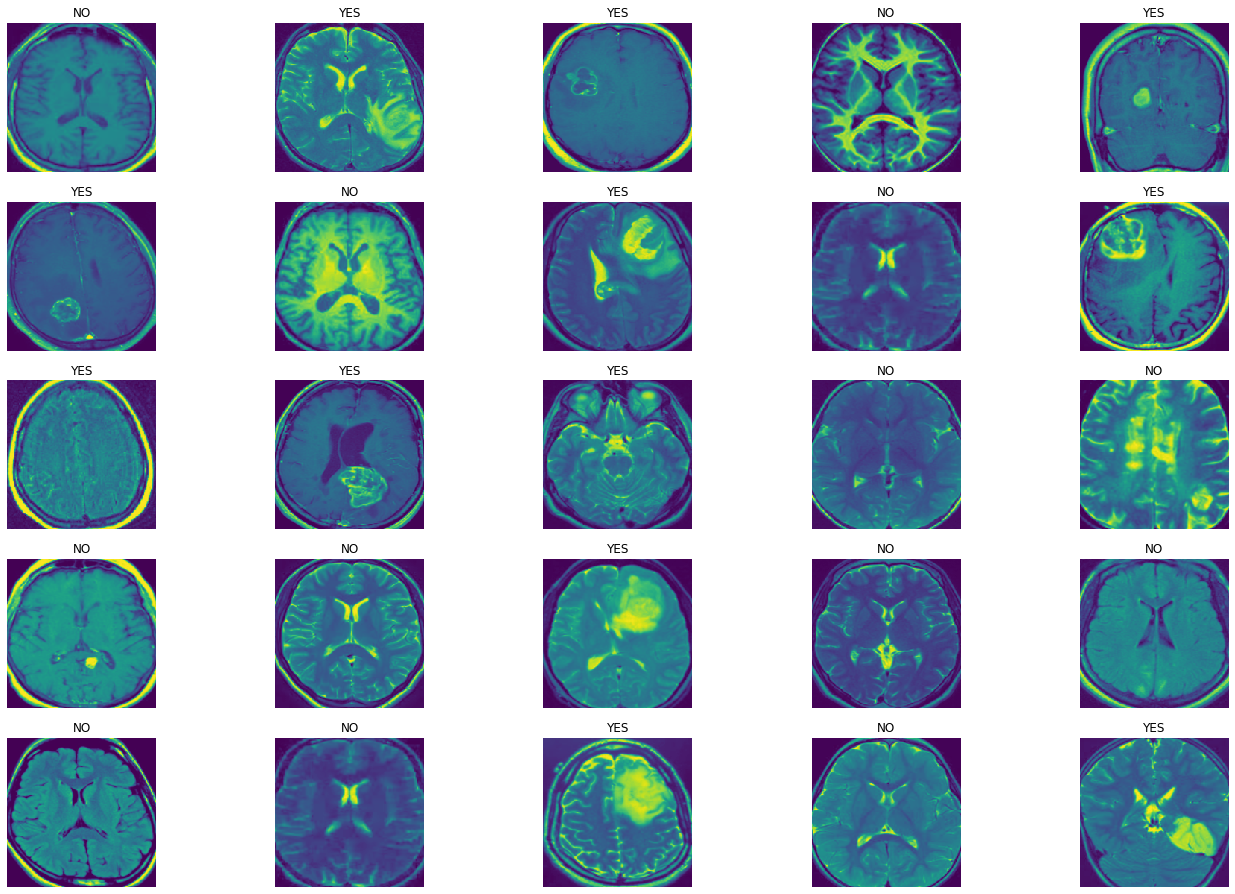

In [191]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(crop_train)-1)
        ax[i,j].imshow(crop_train[rnd_number])
        ax[i,j].set_title(get_classlabel(BrainT_Labels[rnd_number]))
        ax[i,j].axis('off')

## C) Image Enhancement (Contrast streching)
- Following the steps in the article, this is the first part the image pre-processig (the histogram is being equalized in order to increase contrast)

<img src="https://www.dropbox.com/s/r49qeg68go3fplz/Captura2.JPG?dl=1" width="500" align="center">

<Figure size 432x288 with 0 Axes>

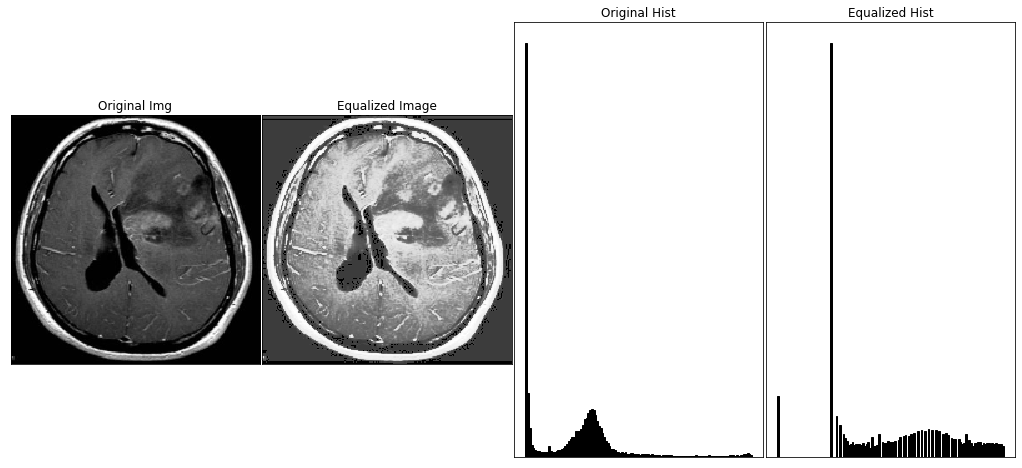

In [159]:
Img= (BrainT_Images[0])

s_eq= cv2.equalizeHist(Img)
fig = plt.figure()
fig.subplots_adjust(hspace=0.0, wspace=0.2)
fig, (ax0,ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=4, figsize=(18, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

ax0.imshow(Img,cmap='gray')
ax0.set_title('Original Img')
ax1.imshow(s_eq, cmap='gray')
ax1.set_title('Equalized Image')
ax2.hist(Img.ravel(), bins=128, range=(0.0, 255), fc='k', ec='k') 
ax2.set_title('Original Hist')
ax3.hist(s_eq.ravel(), bins=128, range=(0.0, 255), fc='k', ec='k') 
ax3.set_title('Equalized Hist')
              
plt.subplots_adjust( hspace=0, wspace=0.01)
plt.show()



In [0]:
# Contrast streching to all images
Contrast_TrainImgs =[]
for i in range (len(crop_train)):
    image = cv2.resize(crop_train[i],(200,200))
    Contrast_TrainImgs.append(cv2.equalizeHist(image))

## D)  Median filter (Noise removal)
- Second part of image pre-processing. It is applied a median filter to remove salt and pepper noise.


<img src="https://www.dropbox.com/s/48ggi2xod2wpro9/Captura3.JPG?dl=1" width="400" align="center">

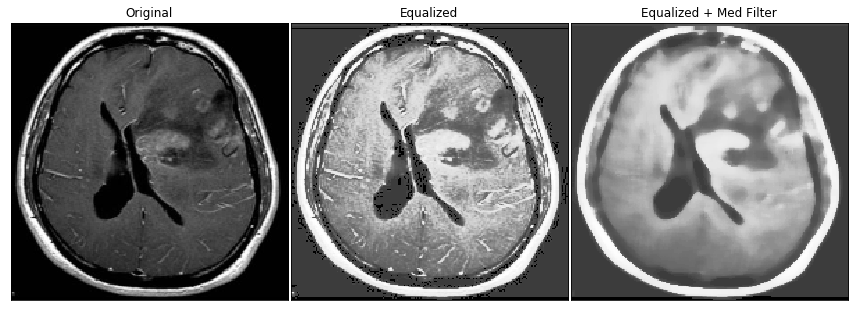

In [161]:
MedFilter= (cv2.medianBlur(s_eq,7)) # 7x7 matrix is applied (like the article)



fig.subplots_adjust(hspace=0.0, wspace=0.2)
fig, (ax0,ax1,ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

ax0.imshow(Img,cmap='gray')
ax0.set_title('Original')
ax1.imshow(s_eq, cmap='gray')
ax1.set_title('Equalized')
ax2.imshow(MedFilter, cmap='gray')
ax2.set_title('Equalized + Med Filter')

plt.subplots_adjust( hspace=0, wspace=0.01)
plt.show()


In [0]:
#ALL IMAGES
MedFilter_Train=[]
kernel_7 = 7
for i in range (len(Contrast_TrainImgs)):
    image = cv2.resize(Contrast_TrainImgs[i],(200,200))
    MedFilter_Train.append(cv2.medianBlur(image,kernel_7))



### Med-filtered Images

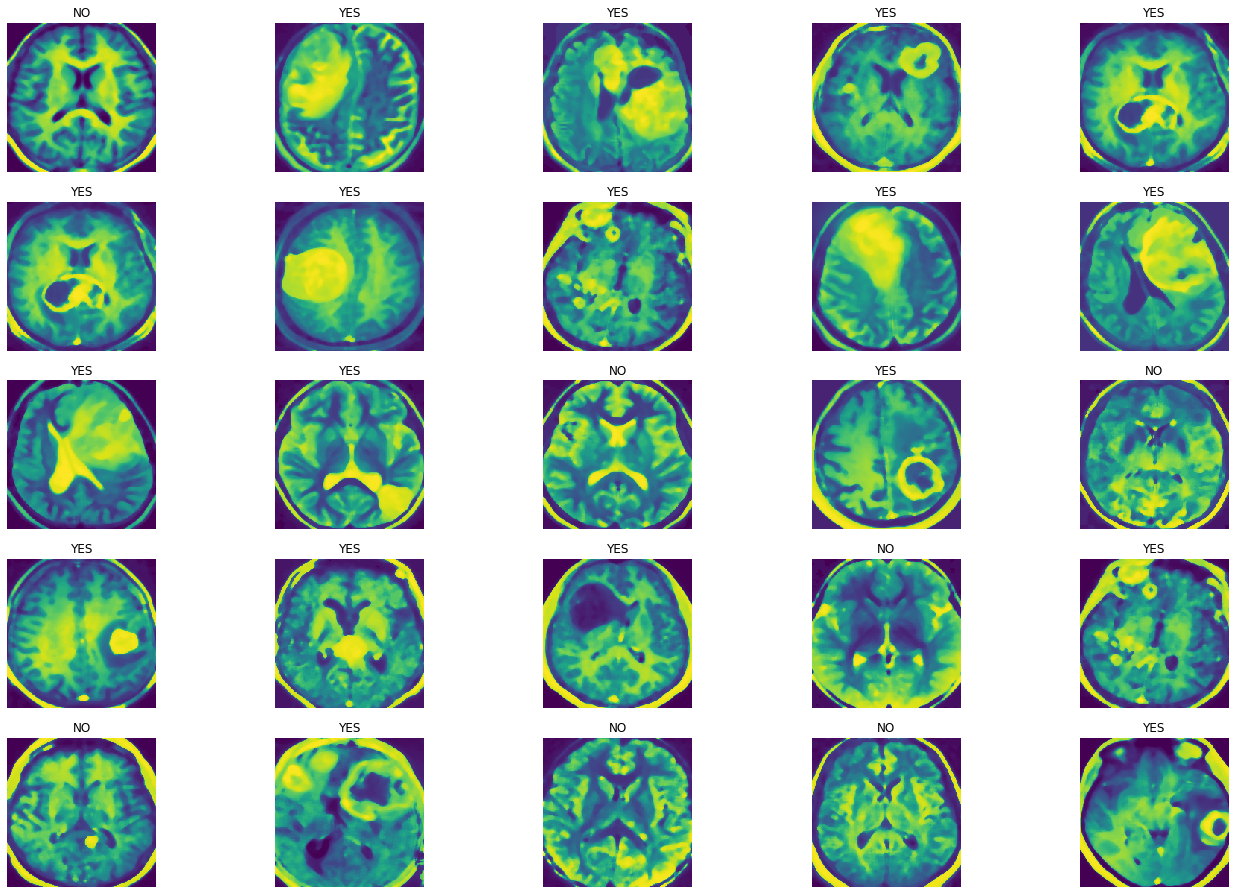

In [190]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(MedFilter_Train)-1)
        ax[i,j].imshow(MedFilter_Train[rnd_number])
        ax[i,j].set_title(get_classlabel(BrainT_Labels[rnd_number]))
        ax[i,j].axis('off')

## E) Segmentation  with  Otsu Thresholding
###  Segmenting the affected area
- This is the last step of image pre-processing. It is applied a Treshold Binary and Otsu filter in order to separate only the affected area.

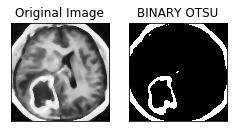

In [167]:
Image_example = MedFilter_Train[1]
ret1,th1 = cv2.threshold(Image_example,215,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2_otsu = cv2.threshold(th1,215,255, cv2.THRESH_OTSU)

titles = ['Original Image','BINARY OTSU']
images = [Image_example, th2_otsu]

for i in  range(2):
    plt.subplot(1,3,i+1), plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

In [0]:
def binaryotsu_seg (IMG):
    ret1,th1 = cv2.threshold(IMG,210,255,cv2.THRESH_BINARY)
    ret2,th2_otsu = cv2.threshold(th1,210,255, cv2.THRESH_OTSU)  
    return  th2_otsu

In [0]:
# Applying Binary Otsu segmentation to All Images
Otsu_train=[]
for i in range (len(MedFilter_Train)):
    
    image = cv2.resize(MedFilter_Train[i],(200,200))
    Otsu_train.append(binaryotsu_seg (image))
    

### Segmented Images

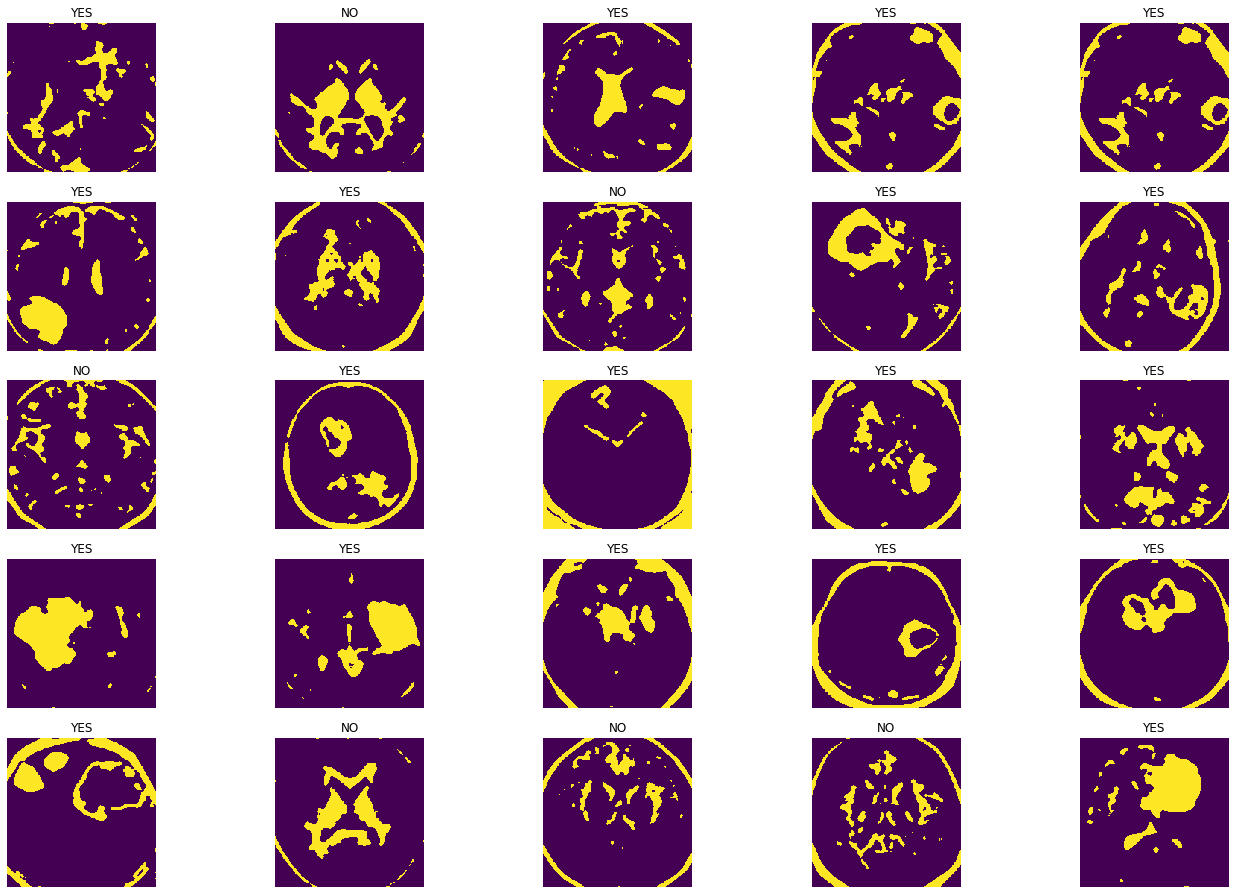

In [170]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        
        rnd_number = randint(0,len(Otsu_train)-1)
        ax[i,j].imshow(Otsu_train[rnd_number])
        ax[i,j].set_title(get_classlabel(BrainT_Labels[rnd_number]))
        ax[i,j].axis('off')

### A close look of the 3 steps

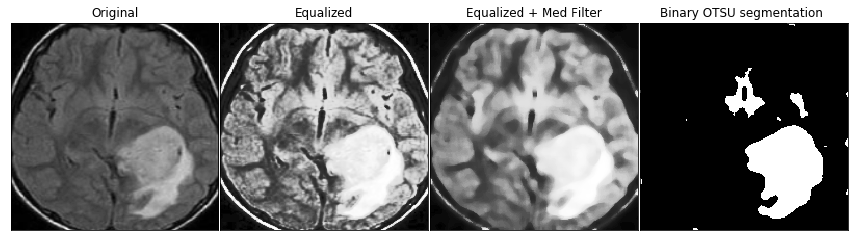

In [171]:
fig.subplots_adjust(hspace=0.0, wspace=0.2)
fig, (ax0,ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

ax0.imshow(crop_train[11],cmap='gray')
ax0.set_title('Original')
ax1.imshow(Contrast_TrainImgs[11], cmap='gray')
ax1.set_title('Equalized')
ax2.imshow(MedFilter_Train[11], cmap='gray')
ax2.set_title('Equalized + Med Filter')
ax3.imshow(Otsu_train[11], cmap='gray')
ax3.set_title('Binary OTSU segmentation ')

plt.subplots_adjust( hspace=0, wspace=0.01)
plt.show()


In [0]:
Otsu_Train_imgs=[]

for i in range(len(Otsu_train)):
    IMG=Otsu_train[i]
    Otsu_Train_imgs.append(IMG)

In [0]:
Images_otsu = np.array(Otsu_Train_imgs)

# Post processing
 
### Identification and classification


<img src="https://www.dropbox.com/s/bzyrxwdpr7uyxq7/Captura4.JPG?dl=1" width="400" align="center">

In [0]:

def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

- In the following part it is calculated the center point of the mass (the tumor) for crop the image and separate it from some parts that are not useful

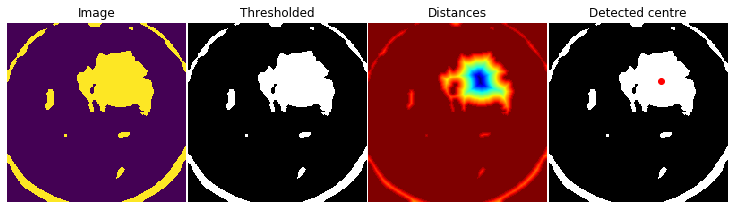

In [179]:
from scipy import ndimage as ndi
import numpy as np
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.color import rgb2gray
from skimage.io import imread

img= Images_otsu[2]
image = rgb2gray(Images_otsu[2]) >   0.01

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)

max_loc = np.unravel_index(distance.argmax(), distance.shape)

fig, axes = plt.subplots(ncols=4, figsize=(10, 2.7))
ax0, ax1, ax2, ax3 = axes

ax0.imshow(img,interpolation='nearest')
ax0.set_title('Image')
ax1.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax1.set_title('Thresholded')
ax2.imshow(-distance, cmap=plt.cm.jet, interpolation='nearest')
ax2.set_title('Distances')
ax3.imshow(rgb2gray(img), cmap=plt.cm.gray, interpolation='nearest')
ax3.set_title('Detected centre')
ax3.scatter(max_loc[1], max_loc[0], color='red')

for ax in axes:
    ax.axis('off')

fig.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)
plt.show()

### Cropping the extra parts of the "Yes/Tumor" images

In [0]:
Images_List_Yes=[]
Images_List_No=[]


X=200
Y=200 
for i in range(len(BrainT_Labels)):  
    if BrainT_Labels[i]== 1:
        
        image = rgb2gray(Images_otsu[i]) >   0.01
        distance = ndi.distance_transform_edt(image)
        max_loc = np.unravel_index(distance.argmax(), distance.shape)
        XW= max_loc[1]
        YH= max_loc[0]
        YSUM =80
        XSUM=90

        if YH + YSUM >= 200 or XW + XSUM >= 200:
            if YH + YSUM >= 200: 
                Y=200
            if  XW + XSUM >= 200:
                X=200
        else:
            Y= YH + YSUM
            X= XW + YSUM


        image2crop = Otsu_Train_imgs[i]   

        crop = image2crop[10:Y, 10:X]
        Images_List_Yes.append(crop)
    else:
        Images_List_No.append(Otsu_Train_imgs[i])
   


    
    

In [0]:
Segmented_images_Yes=[]
Segmented_images_No=[]

for i in range (len(Images_List_Yes)):

    image = cv2.resize(Images_List_Yes[i],(200,200))
    Segmented_images_Yes.append(image) 
    
for i in range (len( Images_List_No)):  
    Segmented_images_No.append(Images_List_No[i]) 
    
        

### In the next part it is shown the MRI's cropped trying to separate the tumor

In [182]:

f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        
        rnd_number = randint(0,len(Segmented_images_Yes)-1)
        ax[i,j].imshow(Segmented_images_Yes[rnd_number])
        ax[i,j].set_title("Yes")
        ax[i,j].axis('off')

In [0]:
# Merge again the part of tumors and no tumors

SegImages_united= []
SegImages2numpy=[]
counter_Yes=0
counter_No=0
for i in range (len(BrainT_Labels)):
  
    if BrainT_Labels[i] == 1:
        
        SegImages_united.append(Segmented_images_Yes[counter_Yes])
        counter_Yes= counter_Yes + 1
    
    else:
      
        SegImages_united.append(Segmented_images_No[counter_No])
        counter_No= counter_No + 1
           
for i in range (len(BrainT_Labels)):
    image = cv2.resize(SegImages_united[i],(200,200))
    SegImages2numpy.append(image)  
        


In [184]:
SegImages = np.array(SegImages2numpy)
SegImages.shape

(244, 200, 200)

# Classification using PCA and Neural networks (MPL Classifier)
- Dimension reduction by PCA
- Clasification with Neural Networks

In [185]:
import matplotlib.pyplot as plt
 
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


np_X= np.array(SegImages)

X=np_X.reshape((np_X.shape[0],np_X.shape[1]*np_X.shape[2]))

print("X shape:",X.shape)


y =  np.array(BrainT_Labels)
target_names = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


# Compute a PCA 
n_components = 100
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
 
# apply PCA transformation
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)



X shape: (244, 40000)


### Fitting the classifier (MPL) to the training set

In [0]:
print("Fitting the classifier to the training set")
clf = MLPClassifier(hidden_layer_sizes=(1000,400), batch_size=min(200, 176), verbose=False, early_stopping=True).fit(X_train_pca, y_train)


Fitting the classifier to the training set


### Results

In [0]:
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.70      0.80        20
           1       0.83      0.97      0.90        31

    accuracy                           0.86        51
   macro avg       0.88      0.83      0.85        51
weighted avg       0.87      0.86      0.86        51



In [0]:
accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)

0.8627450980392157

### Visualization of predicted MRI´s

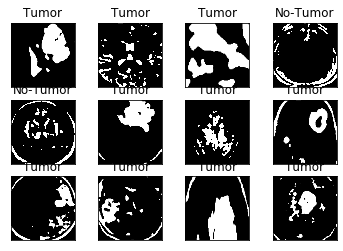

In [0]:

Prediction=[]

from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

def plot_gallery(images, titles, h, w, rows=3, cols=4):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
 
for i in range (len(y_pred)):
    if y_pred[i]== 1:
        Prediction.append('Tumor')
    else: 
        Prediction.append('No-Tumor')
        
    

 

plot_gallery(X_test, Prediction, 200, 200)

# --------------------------------------Homework------------------------------------------------------- 

## Homework 1
- To graph the slopes  (f(x) = mx + b)

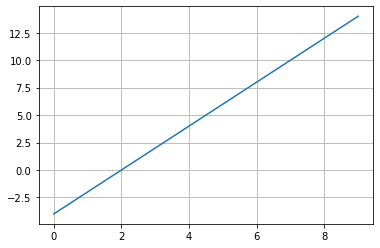

In [0]:

import matplotlib.pyplot as plt
import numpy as np

x = np.array(range(10))
y = (2)*x -4 
 
# Create the plot
plt.plot(x,y)
plt.grid(True)
# Show the plot
plt.show()

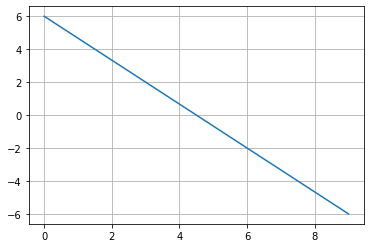

In [0]:
# Create the vectors X and Y
x = np.array(range(10))
y = 6 - (4/3)*x 

# Create the plot
plt.plot(x,y)
plt.grid(True)
# Show the plot
plt.show()

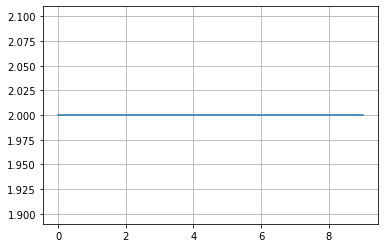

In [0]:
# Create the vectors X and Y
x = np.array(range(10))
y =   (2) + x-x

# Create the plot
plt.plot(x,y)
plt.grid(True)
# Show the plot
plt.show()

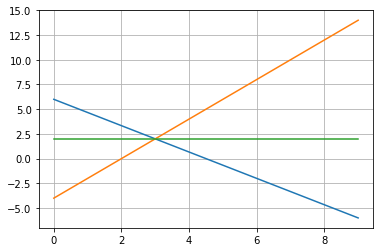

In [0]:
x = np.array(range(10))
y =(2)*x -4 
y2 = 6 - (4/3)*x 
y3 =   (2) + x-x

plt.plot(x,y2)
plt.plot(x,y,y3)
plt.grid(True)

plt.show()

# Homework 2 (Umbralization)
- To obtain the color intensity by the logarithmic function and invert colors


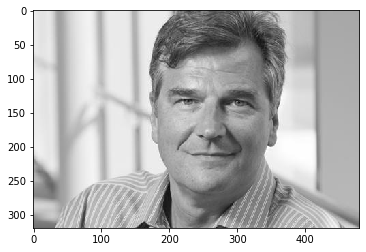

In [0]:
url='https://web.stanford.edu/class/ee368/Handouts/Lectures/Examples/2-Point-Operations/Quantization/face.jpg'

req= urllib.request.urlopen(url)
arr= np.asarray(bytearray(req.read()), dtype=np.uint8)

img=cv2.imdecode(arr,1)

plt.imshow(img, cmap='gray')

### Inverted colors

(17484,)
(320, 480, 3)
uint8


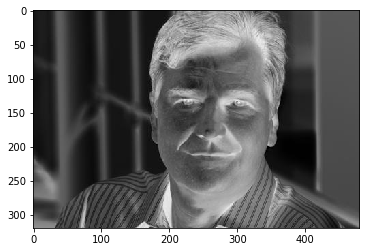

In [0]:

img2=cv2.imdecode(arr,1)
imagem = cv2.bitwise_not(img2)   #Invert the array
#img= np.log(img)

print(arr.shape) # array shape
print(imagem.shape) #image shape
print(imagem.dtype)

plt.imshow(imagem, cmap='gray')

### Logarithmic Function

2.4065401804339546


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


<Figure size 432x288 with 0 Axes>

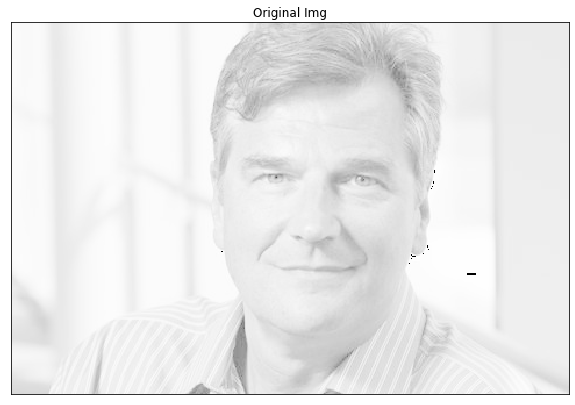

In [0]:
import math
import numpy as np 
import cv2
import matplotlib.pyplot as plt


print (math.log(255,10))
url='https://web.stanford.edu/class/ee368/Handouts/Lectures/Examples/2-Point-Operations/Quantization/face.jpg'

req= urllib.request.urlopen(url)
arr= np.asarray(bytearray(req.read()), dtype=np.uint8)
img=cv2.imdecode(arr,1)

img_log = (np.log(img+1)/(np.log(1+np.max(img))))*255

img_log = np.array(img_log,dtype=np.uint8)


fig = plt.figure()
fig.subplots_adjust(hspace=0.0, wspace=0.2)
fig, (ax0) = plt.subplots(nrows=1, ncols=1, figsize=(10, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

ax0.imshow(img_log,cmap='gray')
ax0.set_title('Original Img')
              
plt.subplots_adjust( hspace=0, wspace=0.01)
plt.show()



# Homework 3
- Getting Histograms of the project's dataset

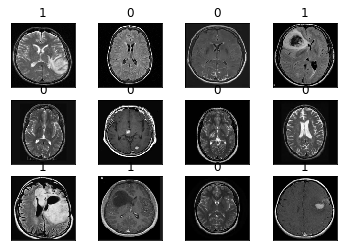

In [0]:



def plot_gallery(images, titles, h, w, rows=3, cols=4):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(BrainT_Images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(BrainT_Labels[i])
        plt.xticks(())
        plt.yticks(())




 
plot_gallery(BrainT_Images, Prediction, 200, 200)

In [0]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.0, wspace=0.2)
fig, (ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11) = plt.subplots(nrows=1, ncols=12, figsize=(12, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

ax0.hist(BrainT_Images[0].ravel(), bins=128, range=(0.0, 255), fc='k', ec='k') 
ax1.hist(BrainT_Images[1].ravel(), bins=128, range=(0.0, 255), fc='k', ec='k') 
ax2.hist(BrainT_Images[2].ravel(), bins=128, range=(0.0, 255), fc='k', ec='k') 
ax3.hist(BrainT_Images[3].ravel(), bins=128, range=(0.0, 255), fc='k', ec='k') 
ax4.hist(BrainT_Images[4].ravel(), bins=128, range=(0.0, 255), fc='k', ec='k') 
ax5.hist(BrainT_Images[5].ravel(), bins=128, range=(0.0, 255), fc='k', ec='k') 
ax6.hist(BrainT_Images[6].ravel(), bins=128, range=(0.0, 255), fc='k', ec='k') 
ax7.hist(BrainT_Images[7].ravel(), bins=128, range=(0.0, 255), fc='k', ec='k')
ax8.hist(BrainT_Images[8].ravel(), bins=128, range=(0.0, 255), fc='k', ec='k') 
ax9.hist(BrainT_Images[9].ravel(), bins=128, range=(0.0, 255), fc='k', ec='k') 
ax10.hist(BrainT_Images[10].ravel(), bins=128, range=(0.0, 255), fc='k', ec='k') 
ax11.hist(BrainT_Images[11].ravel(), bins=128, range=(0.0, 255), fc='k', ec='k') 



plt.subplots_adjust( hspace=0, wspace=0.01)
plt.show()

<Figure size 432x288 with 0 Axes>

# Homework 4 

- Histogram Equalization

In [0]:
import cv2
    
url='https://web.stanford.edu/class/ee368/Handouts/Lectures/Examples/4-Histograms/Histogram_Equalization/moon.jpg'

req= urllib.request.urlopen(url)
arr= np.asarray(bytearray(req.read()), dtype=np.uint8)
img_3=cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)



In [0]:
img_3.shape

(1024, 750)

In [0]:

#img_3= cv2.multiply(img_3,1.3)
#substract = np.abs(cv2.subtract(img_2, img_1)) 
s_equalized= cv2.equalizeHist(img_3)
fig = plt.figure()
fig.subplots_adjust(hspace=0.0, wspace=0.2)
fig, (ax0, ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=4, figsize=(18, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

ax0.imshow(img_3,cmap='gray')
ax1.imshow(s_equalized, cmap='gray')
#ax2.imshow(substract, cmap='gray')
ax2.hist(s_equalized.ravel(), bins=64, range=(0.0, 255), fc='k', ec='k') 
ax3.hist(img_3.ravel(), bins=64, range=(0.0, 255), fc='k', ec='k') 

plt.subplots_adjust( hspace=0, wspace=0.01)
plt.show()

<Figure size 432x288 with 0 Axes>

# Homework 5
- Sobel X and Sobel Y Filters
- Canny Filter

In [0]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
%matplotlib inline
   
url='https://web.stanford.edu/class/ee368/Handouts/Lectures/Examples/8-Linear-Image-Processing/Lowpass_Filter/croppedBike.png'

req= urllib.request.urlopen(url)
arr= np.asarray(bytearray(req.read()), dtype=np.uint8)
img=cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)


In [0]:
sx= np.array([[0,1,0],[1,-4,1],[0,1,0]])
sy = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])  



sblx= cv2.filter2D(img,-1,sx)
sbly= cv2.filter2D(img,-1,sy)

sobelX = cv2.Sobel(sblx, cv2.CV_64F, 1, 0)
sobelY = cv2.Sobel(sbly, cv2.CV_64F, 0, 1)
canny_filter= cv2.Canny(img,0,1)

sobelX = np.uint8(np.absolute(sobelX))
sobelY = np.uint8(np.absolute(sobelY))

sobelCombined = cv2.bitwise_or(sobelX, sobelY)
print(sobelX.max())

fig = plt.figure()
fig.subplots_adjust(hspace=0.0, wspace=0.2)
fig, (ax0, ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=5, figsize=(18, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

ax0.imshow(img,cmap='gray')
ax0.set_title('Original')
ax1.imshow(sobelX, cmap='gray')
ax1.set_title('sobelX')
ax2.imshow(sobelY, cmap='gray')
ax2.set_title('sobelY')
ax3.imshow(sobelCombined, cmap='gray')
ax3.set_title('combined')
ax4.imshow(canny_filter, cmap='gray')
ax4.set_title('Canny')



255


Text(0.5, 1.0, 'Canny')

<Figure size 432x288 with 0 Axes>